<a href="https://colab.research.google.com/github/shivu2507/POS-Tagging-using-RNNs/blob/main/POS_Tagging_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**POS tagging** stands for **Parts of Speech Tagging**, where the given words are labelled accordingly with their respective parts of speech using  **nltk library** and since this is an **offline sequence processing**, **Bidirectional Recurrent Neural Networks(BRNN)** will be used to build the model.**bold text**

In [1]:
import nltk

In [2]:
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('punkt')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

# Importing Libraries & Dataset

In [3]:
# Importing necessary libraries.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import brown, treebank, conll2000

from gensim.models import KeyedVectors

from keras.models import Sequential, Model
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Dense, Input, TimeDistributed, LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

%matplotlib inline

In [4]:
# Loading Corpora from NLTK library with POS tagging.
# tagged_sents returns a list((list(word, tag))) for each sentence.

brown_corpus = brown.tagged_sents(tagset ='universal')
conll_corpus = conll2000.tagged_sents(tagset = 'universal')
treebank_corpus = treebank.tagged_sents(tagset = 'universal')

In [5]:
# Combining the different corpus into single dataset.

tagged_sentences = brown_corpus + conll_corpus + treebank_corpus

## A Glimpse of the dataset

In [6]:
tagged_sentences[5]

[('It', 'PRON'),
 ('recommended', 'VERB'),
 ('that', 'ADP'),
 ('Fulton', 'NOUN'),
 ('legislators', 'NOUN'),
 ('act', 'VERB'),
 ('``', '.'),
 ('to', 'PRT'),
 ('have', 'VERB'),
 ('these', 'DET'),
 ('laws', 'NOUN'),
 ('studied', 'VERB'),
 ('and', 'CONJ'),
 ('revised', 'VERB'),
 ('to', 'ADP'),
 ('the', 'DET'),
 ('end', 'NOUN'),
 ('of', 'ADP'),
 ('modernizing', 'VERB'),
 ('and', 'CONJ'),
 ('improving', 'VERB'),
 ('them', 'PRON'),
 ("''", '.'),
 ('.', '.')]

### Observation

Single datapoint here refers to a sentence in the corpora and each datapoint is a list of tuples of words and tags in a sentence.

# Data Preprocessing

In this problem the input is a sentence and output should be the tags of each word in that  sentence. So from the dataset we need to seperate the words and tags of each sentences.<br>

So, X will be list of words in a sentence<br>
and Y will be list of corresponding POS tags.

In [7]:
X = [] # Stores list of sentences.
Y = [] # Stores list of corresponding POS Tags. 

for sentence in tagged_sentences: #for looping through each datapoint/sentence.

  X_sentence = [] #Stores words of single datapoint/sentence as a list.
  Y_sentence = [] #Stores POS Tags of corresponding sentence as a list.
  
  for word_tags in sentence: #for looping through each word and tag tuple in a single datapoint/sentence.
    X_sentence.append(word_tags[0]) #word_tags[0] refers to first element of the tuple i.e word.
    Y_sentence.append(word_tags[1]) #word_tags[1] refers to second element of the tuple i.e POS tags.

  X.append(X_sentence)
  Y.append(Y_sentence)


In [8]:
num_unique_words = len(set([word.lower() for sentence in X for word in sentence]))
num_unique_tags = len(set([word.lower() for sentence in Y for word in sentence]))

print("Total number of sentences : {}".format(len(X)))
print("Total number of words : {}".format(len([word for sentence in X for word in sentence])))
print("Total number of tags : {}".format(len([word for sentence in Y for word in sentence])))
print("Total number of unique words : {}".format(num_unique_words))
print("Total number of unique tags : {}".format(num_unique_tags))

Total number of sentences : 72202
Total number of words : 1520972
Total number of tags : 1520972
Total number of unique words : 59448
Total number of unique tags : 12


In [9]:
print("Sample Input : ", X[0])
print("Length of Sample Input : {}".format(len(X[0])))
print("Sample Output : ",Y[0])
print("Length of Sample Output : {}".format(len(Y[0])))

Sample Input :  ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
Length of Sample Input : 25
Sample Output :  ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
Length of Sample Output : 25


### Vectorizing X & Y

Since Neural Networks can only deal with numbers, there is a need to convert the text of the inputs and outputs into numbers.<br>

For converting text into numbers, Keras library has an inbuilt function named Tokenizer() which converts input text sequence into integer sequence.

In [10]:
# Creating an instance of Tokenizer() for X and Y.

X_tokenizer = Tokenizer()
Y_tokenizer = Tokenizer()

# Fitting the tokenizer on data.

X_tokenizer.fit_on_texts(X)
Y_tokenizer.fit_on_texts(Y)

# Tokenize the input sequence.

X_tokenized = X_tokenizer.texts_to_sequences(X)
Y_tokenized = Y_tokenizer.texts_to_sequences(Y)

In [11]:
# Comparing raw data with tokenized data.

print("Sample Raw Input : \n", X[0])
print("Sample Tokenized Input : \n",X_tokenized[0])

print("Sample Raw Output : \n", Y[0])
print("Sample Tokenized Output : \n",Y_tokenized[0])

Sample Raw Input : 
 ['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']
Sample Tokenized Input : 
 [1, 5731, 778, 2326, 1842, 39, 853, 34, 1944, 4, 16831, 379, 1343, 1523, 1116, 12, 67, 569, 14, 9, 89, 10208, 252, 205, 3]
Sample Raw Output : 
 ['DET', 'NOUN', 'NOUN', 'ADJ', 'NOUN', 'VERB', 'NOUN', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADJ', 'NOUN', 'NOUN', 'VERB', '.', 'DET', 'NOUN', '.', 'ADP', 'DET', 'NOUN', 'VERB', 'NOUN', '.']
Sample Tokenized Output : 
 [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]


### Fixing the Input Sentence Length

Since we are dealing with sentences, not every sentence is of the same length and hence we need to fix a sentence length and based on this fixed length we need to either truncate longer sequences or pad the shorter sequences. 

In [12]:
# Checking the maximum length.

lengths = [len(sentence) for sentence in X_tokenized]
print("Maximum Length : {}".format(max(lengths)))

Maximum Length : 271


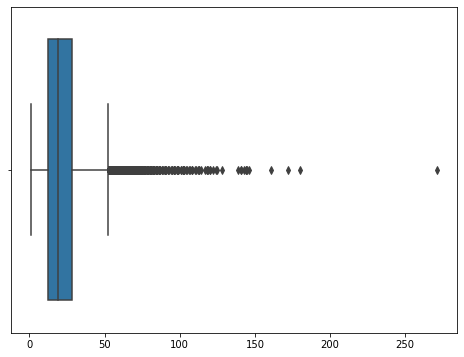

In [13]:
fig = plt.figure(figsize = [8,6])
ax = plt.gca()

ax = sns.boxplot(lengths)
plt.show()

Observation

*   There are a few outliers indicating that there are a few sentences which are exceptionally long and can be either removed or truncated.
*   Truncating is a good choice as sentences which are exceptionally long might be conjunction of two or more sentences.
  





### Padding

We will define a maximum length of 80 and all the sequences will be now of standard size 80 and for the sequences with shorter length it will be padded with zeros from the left side of the sequence and for longer sequences truncation will happen from right side of the sequence.

In [14]:
max_length = 80

X_padded = pad_sequences(X_tokenized, maxlen = max_length, padding = "pre", truncating = "post")
Y_padded = pad_sequences(Y_tokenized, maxlen = max_length, padding = "pre", truncating = "post")

In [15]:
# Comparing the tokenized sequence with padded sequence.

print("Sample Tokenized Input : \n\n", X_tokenized[0])
print("Sample Padded Input : \n\n", X_padded[0])

print("Sample Tokenized Output : \n\n", Y_tokenized[0])
print("Sample Padded Output : \n\n", Y_padded[0])

Sample Tokenized Input : 

 [1, 5731, 778, 2326, 1842, 39, 853, 34, 1944, 4, 16831, 379, 1343, 1523, 1116, 12, 67, 569, 14, 9, 89, 10208, 252, 205, 3]
Sample Padded Input : 

 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1  5731   778  2326  1842
    39   853    34  1944     4 16831   379  1343  1523  1116    12    67
   569    14     9    89 10208   252   205     3]
Sample Tokenized Output : 

 [5, 1, 1, 6, 1, 2, 1, 5, 1, 4, 1, 6, 1, 1, 2, 3, 5, 1, 3, 4, 5, 1, 2, 1, 3]
Sample Padded Output : 

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 1 1 6 1 2 1 5 1 4 1 6 1 1 2 3 5 1 3
 4 5 1 2 1 3]


In [16]:
X, Y = X_padded, Y_padded

### Creating Word Embeddings

Word embedding is a learned representation for texts where words with same meaning have similar representation.

word2vec is a pre-trained model that is used for word embedding and assigns each unique word a corresponding vector.

In [17]:
# Loading word2vec embedding model

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary = True)

--2020-12-05 17:31:31--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.224.19
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.224.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [18]:
# Creating vectors for each unique words in the input.

EMBEDDING_SIZE = 300  #Number of dimensions of the vector space
VOCABULARY_SIZE = len(X_tokenizer.word_index) + 1 # Since we are padding the sequences we are adding 1.

# Creating an empty embedding matrix where each row represents single datapoint and columns represents the dimension of vector space.
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# Creating a word to index dictionary mapping.
word2index = X_tokenizer.word_index

# Copying word2vec vectors to the words present in the input.
for word, index in word2index.items():
  try:
    embedding_weights[index, :] = word2vec[word]
  except KeyError:
    pass

In [19]:
# Checking the dimension of the embedding matrix.

print("Embedding Shape : {}".format(embedding_weights.shape))

Embedding Shape : (59449, 300)


In [20]:
# Looking at embedding of the word 'the'

embedding_weights[X_tokenizer.word_index['the']]

array([ 0.08007812,  0.10498047,  0.04980469,  0.0534668 , -0.06738281,
       -0.12060547,  0.03515625, -0.11865234,  0.04394531,  0.03015137,
       -0.05688477, -0.07617188,  0.01287842,  0.04980469, -0.08496094,
       -0.06347656,  0.00628662, -0.04321289,  0.02026367,  0.01330566,
       -0.01953125,  0.09277344, -0.171875  , -0.00131989,  0.06542969,
        0.05834961, -0.08251953,  0.0859375 , -0.00318909,  0.05859375,
       -0.03491211, -0.0123291 , -0.0480957 , -0.00302124,  0.05639648,
        0.01495361, -0.07226562, -0.05224609,  0.09667969,  0.04296875,
       -0.03540039, -0.07324219,  0.03271484, -0.06176758,  0.00787354,
        0.0035553 , -0.00878906,  0.0390625 ,  0.03833008,  0.04443359,
        0.06982422,  0.01263428, -0.00445557, -0.03320312, -0.04272461,
        0.09765625, -0.02160645, -0.0378418 ,  0.01190186, -0.01391602,
       -0.11328125,  0.09326172, -0.03930664, -0.11621094,  0.02331543,
       -0.01599121,  0.02636719,  0.10742188, -0.00466919,  0.09

### One Hot Encoding the Output

In [21]:
# Using keras to_categorical to one hot encode.
Y = to_categorical(Y)

# Checking the shape of Y
print("Number of Sentences : {}".format(Y.shape[0]))
print("Number of Sequences/Timesteps : {}".format(Y.shape[1]))
print("Number of Classes : {}".format(Y.shape[2]))

Number of Sentences : 72202
Number of Sequences/Timesteps : 80
Number of Classes : 13


## Splitting the Data

Split the data into training, validation and testing datasets.

In [22]:
# splitting entire dataset into train and test sets.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 43)

# splitting the training data into training and validation sets.

X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 43)

In [25]:
print('Training Data')
print("Shape of input sequences : {}".format(X_train.shape))
print('Shape of output sequences : {}'.format(Y_train.shape))
print("-"*50)

print('Validation Data')
print("Shape of input sequences : {}".format(X_valid.shape))
print('Shape of output sequences : {}'.format(Y_valid.shape))
print("-"*50)

print('Testing Data')
print("Shape of input sequences : {}".format(X_test.shape))
print('Shape of output sequences : {}'.format(Y_test.shape))

Training Data
Shape of input sequences : (46208, 80)
Shape of output sequences : (46208, 80, 13)
--------------------------------------------------
Validation Data
Shape of input sequences : (11553, 80)
Shape of output sequences : (11553, 80, 13)
--------------------------------------------------
Testing Data
Shape of input sequences : (14441, 80)
Shape of output sequences : (14441, 80, 13)


# Building Models

## Simple RNN Model 1

Building a plain RNN with randomly initialised embeddings and untrainable embedding weights with an architecure of 64 RNN cells.

In [30]:
num_classes = Y.shape[2]

# Architecture of Simple RNN

simple_rnn = Sequential()

# adding an embedding layer to randomly initialise the embedding vectors. 
simple_rnn.add(Embedding(input_dim = VOCABULARY_SIZE, output_dim = EMBEDDING_SIZE, input_length = max_length, trainable = False, ))

# adding an RNN layer with 64 RNN cells.
simple_rnn.add(SimpleRNN(64, return_sequences = True))

# adding time distributed layer - to predict at every timestep for each sequence.
simple_rnn.add(TimeDistributed(Dense(num_classes, activation = "softmax")))

### Compiling the model

In [33]:
simple_rnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

# Checking the summary of the model.

simple_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 300)           17834700  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 80, 64)            23360     
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 13)            845       
Total params: 17,858,905
Trainable params: 24,205
Non-trainable params: 17,834,700
_________________________________________________________________


### Fit Model

In [34]:
simple_rnn_training = simple_rnn.fit(X_train, Y_train, batch_size = 128, epochs = 10, validation_data = (X_valid, Y_valid))

Epoch 1/10
361/361 [==============================] - 27s 75ms/step - loss: 0.5945 - acc: 0.8265 - val_loss: 0.4098 - val_acc: 0.8727
Epoch 2/10
361/361 [==============================] - 26s 72ms/step - loss: 0.3384 - acc: 0.8976 - val_loss: 0.2869 - val_acc: 0.9138
Epoch 3/10
361/361 [==============================] - 25s 68ms/step - loss: 0.2574 - acc: 0.9204 - val_loss: 0.2350 - val_acc: 0.9262
Epoch 4/10
361/361 [==============================] - 25s 69ms/step - loss: 0.2193 - acc: 0.9297 - val_loss: 0.2067 - val_acc: 0.9330
Epoch 5/10
361/361 [==============================] - 28s 77ms/step - loss: 0.1965 - acc: 0.9362 - val_loss: 0.1886 - val_acc: 0.9386
Epoch 6/10
361/361 [==============================] - 27s 76ms/step - loss: 0.1813 - acc: 0.9407 - val_loss: 0.1770 - val_acc: 0.9414
Epoch 7/10
361/361 [==============================] - 26s 72ms/step - loss: 0.1713 - acc: 0.9434 - val_loss: 0.1685 - val_acc: 0.9442
Epoch 8/10
361/361 [==============================] - 26s 72ms

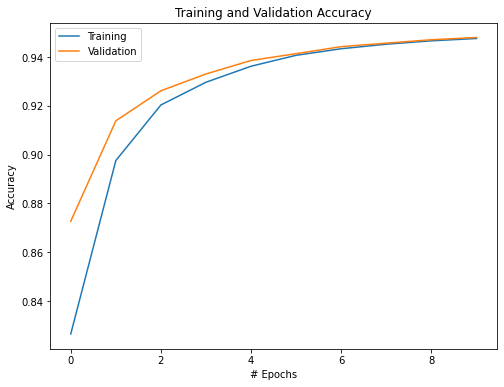

In [36]:
plt.figure(figsize = [8,6])
plt.plot(simple_rnn_training.history['acc'])
plt.plot(simple_rnn_training.history['val_acc'])
plt.title("Training and Validation Accuracy")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy")
plt.legend(['Training', "Validation"], loc = 'best')
plt.show()